# Binary Classification with SageMaker XGBoost

**Goal:** Train an XGBoost binary classifier to distinguish **Benign (0)** from **Malicious (1)** network traffic using the 12 engineered features produced by the feature-engineering pipeline.

**Data source:** Athena table `aai540_eda.split_v2` (pre-split into `train`, `val`, `test`, `prod` partitions).

**Approach:**
1. Query train / validation / test splits from Athena
2. Upload headerless CSV to S3 (label in the first column — required by SageMaker built-in XGBoost)
3. Run a hyperparameter tuning job (5 trials) optimising **validation AUC**
4. Evaluate the best model on the held-out test set

## Setup

In [11]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
from sagemaker import get_execution_role, image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.tuner import (
    HyperparameterTuner,
    IntegerParameter,
    ContinuousParameter,
)
from sqlalchemy import create_engine, text
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
import json, io, os, csv

sess = sagemaker.Session()
region = boto3.Session().region_name
role = get_execution_role()
bucket = sess.default_bucket()

print(f"Region : {region}")
print(f"Role   : {role}")
print(f"Bucket : {bucket}")

Region : us-east-1
Role   : arn:aws:iam::933747558592:role/LabRole
Bucket : sagemaker-us-east-1-933747558592


In [12]:
database_name = "aai540_eda"
engine = create_engine(
    f"awsathena+rest://@athena.{region}.amazonaws.com:443/{database_name}",
    connect_args={
        "s3_staging_dir": f"s3://{bucket}/athena/staging/",
        "region_name": region,
    },
)
print("Athena engine ready")

Athena engine ready


## Load data from Athena

In [ ]:
check_query = f"SELECT * FROM {database_name}.split_v2 LIMIT 1"
df_check = pd.read_sql(check_query, engine)
print(f"Columns in split_v2: {list(df_check.columns)}")
print(f"\nTotal columns: {len(df_check.columns)}")

Columns in split_v2: ['duration', 'pkt_total', 'bytes_total', 'pkt_fwd', 'pkt_bwd', 'bytes_fwd', 'bytes_bwd', 'label', 'original_attack_type', 'attack_category', 'source_dataset', 'pkt_rate', 'byte_rate', 'bytes_per_pkt', 'pkt_ratio', 'byte_ratio', 'split_bucket', 'data_split']

Total columns: 18


In [14]:
FEATURE_COLS = [
    "duration", "pkt_total", "bytes_total",
    "pkt_fwd", "pkt_bwd", "bytes_fwd", "bytes_bwd",
    "pkt_rate", "byte_rate", "bytes_per_pkt",
    "pkt_ratio", "byte_ratio",
]
LABEL_COL = "label"

columns = ", ".join([LABEL_COL] + FEATURE_COLS)

query = f"""
SELECT {columns}, data_split
FROM {database_name}.split_v2
WHERE data_split IN ('train', 'val', 'test')
"""

print("Running Athena query …")
df_all = pd.read_sql(query, engine)
print(f"Total rows returned: {len(df_all):,}")
df_all["data_split"].value_counts()

Running Athena query …
Total rows returned: 300,505


data_split
train    200365
val       50070
test      50070
Name: count, dtype: int64

In [ ]:
df_train = df_all.loc[df_all["data_split"] == "train", [LABEL_COL] + FEATURE_COLS].reset_index(drop=True)
df_val   = df_all.loc[df_all["data_split"] == "val",   [LABEL_COL] + FEATURE_COLS].reset_index(drop=True)
df_test  = df_all.loc[df_all["data_split"] == "test",  [LABEL_COL] + FEATURE_COLS].reset_index(drop=True)

del df_all

print(f"Train : {len(df_train):>8,}  (label 1: {df_train[LABEL_COL].sum():,.0f}  |  label 0: {(df_train[LABEL_COL] == 0).sum():,.0f})")
print(f"Val   : {len(df_val):>8,}  (label 1: {df_val[LABEL_COL].sum():,.0f}  |  label 0: {(df_val[LABEL_COL] == 0).sum():,.0f})")
print(f"Test  : {len(df_test):>8,}  (label 1: {df_test[LABEL_COL].sum():,.0f}  |  label 0: {(df_test[LABEL_COL] == 0).sum():,.0f})")

Train :  200,365  (label 1: 154,750  |  label 0: 45,615)
Val   :   50,070  (label 1: 38,680  |  label 0: 11,390)
Test  :   50,070  (label 1: 38,680  |  label 0: 11,390)


In [ ]:
neg_count = (df_train[LABEL_COL] == 0).sum()
pos_count = (df_train[LABEL_COL] == 1).sum()
scale_pos_weight = float(neg_count / pos_count)

print(f"Negative (benign)  : {neg_count:,}")
print(f"Positive (attack)  : {pos_count:,}")
print(f"scale_pos_weight   : {scale_pos_weight:.4f}")

Negative (benign)  : 45,615
Positive (attack)  : 154,750
scale_pos_weight   : 0.2948


## Upload data to S3

SageMaker's built-in XGBoost expects CSV with the label as the first column. We write each split to its own S3 prefix.

In [17]:
s3_prefix = "aai540/model/xgboost-binary"
s3 = boto3.client("s3")


def upload_df_to_s3(df, split_name):
    """Write a DataFrame as headerless CSV and upload to S3."""
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, header=False)
    key = f"{s3_prefix}/{split_name}/data.csv"
    s3.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
    uri = f"s3://{bucket}/{key}"
    print(f"  {split_name:>10} → {uri}  ({len(df):,} rows)")
    return uri


print("Uploading splits to S3 …")
s3_train = upload_df_to_s3(df_train, "train")
s3_val   = upload_df_to_s3(df_val,   "validation")
s3_test  = upload_df_to_s3(df_test,  "test")
print("Done.")

Uploading splits to S3 …
       train → s3://sagemaker-us-east-1-933747558592/aai540/model/xgboost-binary/train/data.csv  (200,365 rows)
  validation → s3://sagemaker-us-east-1-933747558592/aai540/model/xgboost-binary/validation/data.csv  (50,070 rows)
        test → s3://sagemaker-us-east-1-933747558592/aai540/model/xgboost-binary/test/data.csv  (50,070 rows)
Done.


In [ ]:
train_input = TrainingInput(s3_train, content_type="text/csv")
val_input   = TrainingInput(s3_val,   content_type="text/csv")

## Hyperparameter Tuning

We use the SageMaker built-in XGBoost container. A `HyperparameterTuner` runs 5 training jobs searching for the combination that maximises validation AUC

Static hyperparameters:
- `objective = binary:logistic`
- `eval_metric = auc`
- `num_round = 200`
- `scale_pos_weight` — computed from the training set to counteract class imbalance

Tuned hyperparameters:
| Parameter | Range |
|-----------|-------|
| `max_depth` | 3 – 10 |
| `eta` (learning rate) | 0.01 – 0.3 |
| `min_child_weight` | 1 – 10 |
| `subsample` | 0.5 – 1.0 |
| `gamma` | 0 – 5 |

In [ ]:
# XGBoost container image
xgb_image = image_uris.retrieve("xgboost", region, version="1.5-1")
print(f"XGBoost image: {xgb_image}")

# Base estimator
xgb_estimator = Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=f"s3://{bucket}/{s3_prefix}/output",
    sagemaker_session=sess,
    base_job_name="xgb-binary",
)

# Static hyperparameters
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=200,
    scale_pos_weight=round(scale_pos_weight, 4),
)

print("Estimator configured.")

XGBoost image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1
Estimator configured.


In [ ]:
# Hyperparameter ranges
hyperparameter_ranges = {
    "max_depth":        IntegerParameter(3, 10),
    "eta":              ContinuousParameter(0.01, 0.3, scaling_type="Logarithmic"),
    "min_child_weight": IntegerParameter(1, 10),
    "subsample":        ContinuousParameter(0.5, 1.0),
    "gamma":            ContinuousParameter(0.0, 5.0),
}

# Tuner
tuner = HyperparameterTuner(
    estimator=xgb_estimator,
    objective_metric_name="validation:auc",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=2,
    strategy="Bayesian",
    objective_type="Maximize",
    base_tuning_job_name="xgb-binary-tune",
)

print("Tuner configured — 5 jobs, 2 parallel, Bayesian strategy.")

Tuner configured — 5 jobs, 2 parallel, Bayesian strategy.


In [ ]:
# Launch tuning job
tuner.fit({"train": train_input, "validation": val_input}, wait=True)
print("Tuning complete.")

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................!
Tuning complete.


In [ ]:
# Best hyperparameters
best_job = tuner.best_training_job()
print(f"Best training job: {best_job}")

# Retrieve tuning results as a DataFrame
tuning_results = sagemaker.HyperparameterTuningJobAnalytics(
    tuner.latest_tuning_job.name, sagemaker_session=sess
).dataframe()
tuning_results = tuning_results.sort_values("FinalObjectiveValue", ascending=False)
print("\nTuning results (sorted by validation AUC):")
display(tuning_results[
    ["TrainingJobName", "FinalObjectiveValue", "TrainingJobStatus"]
    + [c for c in tuning_results.columns if c.startswith("eta") or c.startswith("max_depth")
       or c.startswith("min_child") or c.startswith("subsample") or c.startswith("gamma")]
])

Best training job: xgb-binary-tune-260210-0309-002-1fe110ff

Tuning results (sorted by validation AUC):


,TrainingJobName,FinalObjectiveValue,TrainingJobStatus,eta,gamma,max_depth,min_child_weight,subsample
3,xgb-binary-tune-260210-0309-002-1fe110ff,0.91663,Completed,0.063426,4.348286,8.0,2.0,0.951706
4,xgb-binary-tune-260210-0309-001-0d9a1941,0.91321,Completed,0.102219,4.696792,8.0,9.0,0.794658
0,xgb-binary-tune-260210-0309-005-345d4e44,0.90241,Completed,0.214205,2.572154,3.0,10.0,0.811549
1,xgb-binary-tune-260210-0309-004-b78cb7c5,0.89348,Completed,0.098826,4.374437,4.0,7.0,0.541670
2,xgb-binary-tune-260210-0309-003-898fec83,0.85547,Completed,0.017450,1.410234,5.0,5.0,0.776597


## Evaluate on the test set

Deploy the best model from the tuning job to a real-time endpoint, run predictions on the test split, and compute classification metrics.

In [23]:
# Deploy best model
predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)
print(f"Endpoint: {predictor.endpoint_name}")


2026-02-10 03:12:27 Starting - Preparing the instances for training
2026-02-10 03:12:27 Downloading - Downloading the training image
2026-02-10 03:12:27 Training - Training image download completed. Training in progress.
2026-02-10 03:12:27 Uploading - Uploading generated training model
2026-02-10 03:12:27 Completed - Resource reused by training job: xgb-binary-tune-260210-0309-004-b78cb7c5
-----!Endpoint: xgb-binary-tune-260210-0309-002-1fe110ff


In [ ]:
# Predict on test set (batch through endpoint)
BATCH_SIZE = 500
y_true = df_test[LABEL_COL].values
X_test = df_test[FEATURE_COLS].values
y_prob = []

print(f"Running predictions on {len(X_test):,} test rows …")
for start in range(0, len(X_test), BATCH_SIZE):
    batch = X_test[start : start + BATCH_SIZE]
    response = predictor.predict(batch)
    # response is a list of lists of strings
    y_prob.extend([float(row[0]) for row in response])

y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)
print("Predictions complete.")

Running predictions on 50,070 test rows …
Predictions complete.


In [ ]:
# Classification metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
auc_roc   = roc_auc_score(y_true, y_prob)

print("=" * 50)
print("        Test Set Evaluation Metrics")
print("=" * 50)
print(f"  Accuracy  : {accuracy:.4f}")
print(f"  Precision : {precision:.4f}")
print(f"  Recall    : {recall:.4f}")
print(f"  F1 Score  : {f1:.4f}")
print(f"  AUC-ROC   : {auc_roc:.4f}")
print("=" * 50)
print()
print(classification_report(y_true, y_pred, target_names=["Benign (0)", "Attack (1)"]))

        Test Set Evaluation Metrics
  Accuracy  : 0.2423
  Precision : 1.0000
  Recall    : 0.0191
  F1 Score  : 0.0375
  AUC-ROC   : 0.9016

              precision    recall  f1-score   support

  Benign (0)       0.23      1.00      0.38     11390
  Attack (1)       1.00      0.02      0.04     38680

    accuracy                           0.24     50070
   macro avg       0.62      0.51      0.21     50070
weighted avg       0.83      0.24      0.11     50070



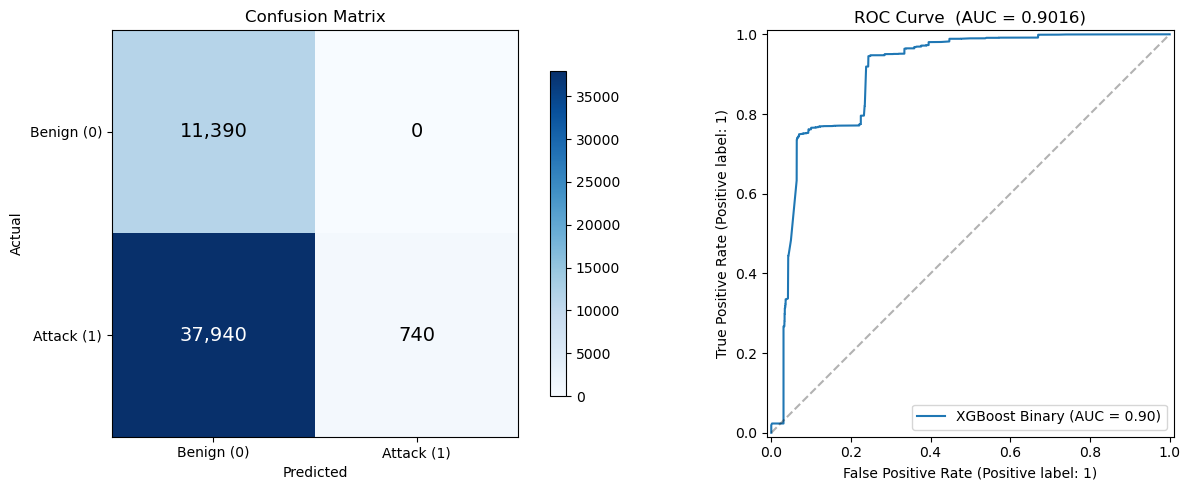

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
im = axes[0].imshow(cm, cmap="Blues")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(["Benign (0)", "Attack (1)"])
axes[0].set_yticklabels(["Benign (0)", "Attack (1)"])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix")
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f"{cm[i, j]:,}", ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=14)
fig.colorbar(im, ax=axes[0], shrink=0.8)

# ROC curve
RocCurveDisplay.from_predictions(y_true, y_prob, ax=axes[1], name="XGBoost Binary")
axes[1].set_title(f"ROC Curve  (AUC = {auc_roc:.4f})")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save evaluation metrics to S3
metrics = {
    "model": "xgboost-binary",
    "best_training_job": best_job,
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1,
    "test_auc_roc": auc_roc,
    "confusion_matrix": cm.tolist(),
}

metrics_key = f"{s3_prefix}/evaluation/test_metrics.json"
s3.put_object(
    Bucket=bucket,
    Key=metrics_key,
    Body=json.dumps(metrics),
    ContentType="application/json",
)
print(f"Metrics saved to s3://{bucket}/{metrics_key}")

Metrics saved to s3://sagemaker-us-east-1-933747558592/aai540/model/xgboost-binary/evaluation/test_metrics.json


## Clean up

Delete the real-time endpoint to avoid ongoing charges. The model artifact remains in S3 for later use.

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)
print("Endpoint deleted.")

best_model_s3 = f"s3://{bucket}/{s3_prefix}/output/{best_job}/output/model.tar.gz"
print(f"\nModel artifact: {best_model_s3}")
print("This can be used for Stage 2 (multi-class) or batch inference.")

Endpoint deleted.

Model artifact: s3://sagemaker-us-east-1-933747558592/aai540/model/xgboost-binary/output/xgb-binary-tune-260210-0309-002-1fe110ff/output/model.tar.gz
This can be used for Stage 2 (multi-class) or batch inference.
